# Hypercube model

Let's start by playing with a hypercube model.
In this model we imagine that every person has a number of neighbours that they could potentially get/give covid-19 from/to.

If we imagined a matrix, then each person would have 8 neighbours.
In a cube tensor, each person would have $8 + 9 + 9 = 26$ neighbours.
In an n-dimensional tensor, each person has $3^n - 1$ neighbours.

Let's begin with an easy tensor. 0 represents someone who is uninfected, 1 represents someone who is infected, and NA represents either someone who doesn't exist or someone who is no longer at risk (dead or immune).

In [457]:
N = 5
total_people = 100000

tensor = zeros(Union{Missing, Int64}, (Int(ceil(total_people^(1/N))) for i in 1:N)...)
total_neighbours = 3^N - 1

using StatsBase
locs = sample(1:((Int(ceil(total_people^(1/N))))^N),((Int(ceil(total_people^(1/N))))^N - total_people), replace=false)
tensor[locs] .= missing;

We begin by making a few `n0` people unwell.

In [458]:
n0 = 10
locs = sample(1:length(tensor), n0, replace=false)
tensor[locs] .= 1;
sum(skipmissing(tensor)) ##should be 5

10

First we iterate over each of the people who are unwell.
The probability of them dying in that step is `mortrate`.
The probability of them becoming well in that step is `healrate`.

Then each step we iterate over the neighbours of people with illness.
The average number of people who become infected by someone who is infected is `r0`.
This must be done in the average time of being infected, i.e. 1/(`mortrate` + `healrate`).
Therefore the average number of infections per step is `r0` * (`mortrate` + `healrate`).

The probability of each of the neighbours becoming 1 is `r0` * (`mortrate` + `healrate`) * 1 / `total_neighbours`.
If someone has two neighbours they will be iterated over twice.

Then we can sum the array to know the number infected.

In [459]:
function infect_neighbours(array::Array{Union{Int64, Missing}}, prob_infection)
    num_infected = 0
    for infected in findall(coalesce.(array .== 1, false))
        neighbours = get_neighbours(array, infected)
        for i in eachindex(neighbours)
            neighbours[i], change = infect(neighbours[i], prob_infection)
            num_infected += change
        end

    end
    return array, num_infected
end

infect_neighbours (generic function with 1 method)

In [460]:
mortrate = 0.001
healrate = 0.1
r0 = 3
prob_infection = r0 * (mortrate + healrate) / (3^N - 1)

0.0012520661157024795

In [461]:
function infect(value::Union{Int64, Missing}, prob_infection::Float64)
    if (coalesce(value,-1) == 0) && (rand() < prob_infection)
        return 1, 1
    end
    return value, 0
end

infect (generic function with 1 method)

In [462]:
function find_indices(pos, len)
    start = pos - 1
    if pos == 1
        start = 1
    end
    last = pos + 1
    if pos == len
        last = len
    end
    return(start:last)
end

find_indices (generic function with 1 method)

In [463]:
function get_neighbours(array, cartind)
    len = size(array)[1]
    tpl = Tuple(cartind)

    return(view(array, (find_indices(i, len) for i in tpl)...))
    
end

get_neighbours (generic function with 1 method)

In [464]:
function heal_or_die(array, mortrate, healrate)
    nmort = 0
    nheal = 0
    
    for i in eachindex(array)
        if coalesce(array[i],0) == 1
            rnd = rand()
            if rnd < mortrate
                array[i] = missing
                nmort += 1
            end
            if rnd < (mortrate + healrate) && rnd > mortrate
                array[i] = missing
                nheal += 1
            end
        end
    end
    return(array,nmort,nheal)
end

heal_or_die (generic function with 1 method)

In [465]:
# get_neighbours(tensor, findall(coalesce.(tensor .== 1, false))[3])

In [466]:
infected = [sum(skipmissing(tensor))]
deaths = [0]
survivals = [0]
infections = [sum(skipmissing(tensor))]

for step in 1:1000
    tensor, ndead, nhealed = heal_or_die(tensor, mortrate, healrate)
    append!(deaths, ndead)
    append!(survivals, nhealed)
    tensor, num_infected = infect_neighbours(tensor, prob_infection)
    append!(infected, sum(skipmissing(tensor)))
    append!(infections, num_infected)
end

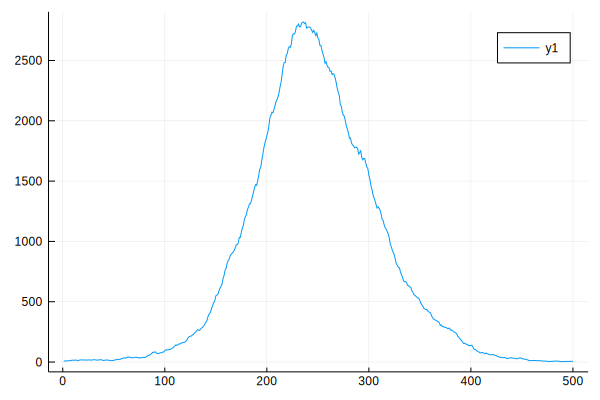

In [472]:
using Plots
plot(infected[1:500])

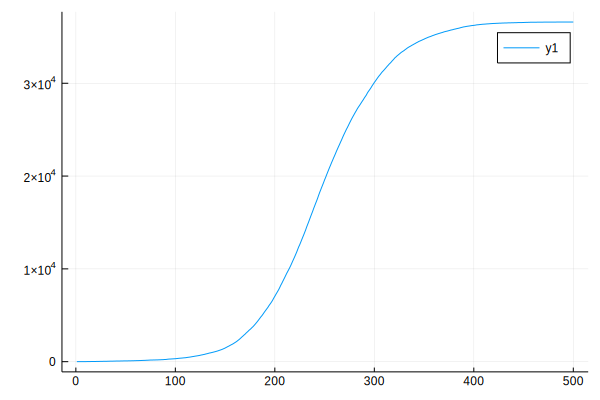

In [473]:
plot(cumsum(survivals)[1:500])

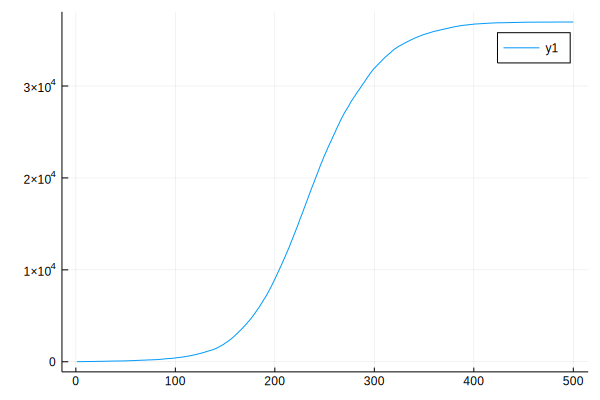

In [474]:
plot(cumsum(infections)[1:500])

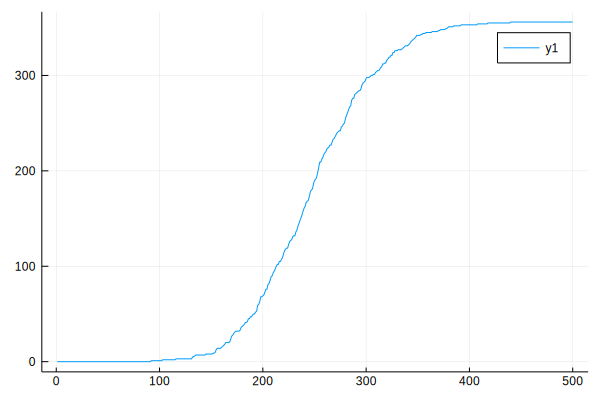

In [475]:
plot(cumsum(deaths)[1:500])